# Stock Grouping v1.0

Group stocks in SET100 using unsupervised learning methods: PCA and K-means.

1. Stock data with technical features were previously loaded into the database. Start by query database for time period to perform grouping. In this experiment the date selected is 2016-01-05. There are 142 stocks in the database.  

2. **Choose 5 features** from the database. These are the attributes downloaded from Datastream, with some minor tweak.  MACD, 
  MV, VO came directly from Datastream.  
  P_SMA_5, VO_SMA_20 were P and VO attribute with Simple Moving Average applied, n=5, n=20 respectively.  
  vol_st and mv_st were the short-term volume and momentum indicator. Formula to be written out, but the concepts follow from discussion.

3. Step to perform clustering as follow:

**Stock Grouping Algorithm:**

*Step 0:*

Each input row is feature vector of size 7 as describe above, and two values for label are stock name and date. There are 142 rows, corresponding to the stocks at the selected time. 

*Step 1:*

First, apply MinMaxScaler to the features. This handles MV and VO attribute that have large magnitude that will skew all other features.

*Step 2:*

Second step, PCA with configuration targeting 3-components are fitted to the data. This means PCA gives three principle components which explains the variance in the data the most.

*Step 3:*

Third step, the input row is transform with PCA resulting in three components for each stock. This dataset is the derived dataset that were transformed with PCA.

*Step 4:*

Fourth step, the derived dataset from third step is clustered (break into three groups) using K-means clustering method, with k=3. This basic setup is based on principle that K-means requires Euclidean space in order to calculate distance to determine the location of centroids and the nearest group for individual stock assignment to the group.

*Step 5:*

K-means clustering **algorithm terminated with all items (the stocks in database) labeled**. This experiment establish base case for using PCA with K-means to automically classify stocks into groups according to similarity found in their _features purly calculated from data_.

### Result

Three groups identified have membership count as follow: first group contains 9 stocks, second ground contains 112 stocks, third group contains 21 stocks.

To visualize each group, currently scatter plot using PC1 and PC2 in each group is used. Tables and charts are at the bottom of this notebook.


Further ideas for grouping may be investigated further. How to measure the quality of the grouping TBD.

In [1]:
import sys, os, os.path
if not 'EXPERIMENT_HOME' in os.environ: # Configure local paths if not already defined
    ML_HOME = os.path.abspath(os.path.join("/home/jovyan", "ml_home")) # ML workspace
    EXPERIMENT_HOME = os.path.abspath(os.path.join(ML_HOME, "..")) # Experiment workspace
    DATA_HOME = os.path.abspath(os.path.join(EXPERIMENT_HOME,"dataset")) # Dataset location
    os.environ["EXPERIMENT_HOME"] = EXPERIMENT_HOME
    os.environ["DATA_HOME"] = DATA_HOME
    sys.path.insert(0, EXPERIMENT_HOME)
    sys.path.insert(0, ML_HOME) # Add to path so can load our library
    os.chdir(EXPERIMENT_HOME) # Change working directory to experiment workspace
print("Experiment Home: ", os.path.abspath(os.curdir), "; Data Home:", DATA_HOME)

Experiment Home:  /home/jovyan ; Data Home: /home/jovyan/dataset


In [2]:
from datetime import datetime
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import datetime as dt
import xlrd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from data.snapshot import SET100, SET100_db_engine, make_index
engine = SET100_db_engine()

In [4]:
# Select by date
sql = """SELECT f.* FROM set100_daily_features f
WHERE f.date BETWEEN '2016-01-05' AND '2016-01-05';"""
df_read = pd.read_sql(sql, engine)
df_read

,stock,date,VO,VO_SMA_20,VO_SMA_100,vol_st,MV,MV_SMA_20,MV_SMA_100,mv_st,P,P_SMA_5,P_SMA_20,p_st,MACD
0,ASIA AVIATION,2016-01-05,39276900.0,17876495.0,16439221.0,0.087430,25219990000.0,2.394687e+10,2.238323e+10,0.069858,5.2,5.220,4.9375,0.057215,0.14
1,ADVANCED INFO SER.,2016-01-05,59688900.0,25247980.0,9966121.0,1.533381,389475300000.0,5.059463e+11,6.395571e+11,-0.208911,131,146.000,170.1750,-0.142060,-17.06
2,AE.THANA SINSAP (THAI.),2016-01-05,175900.0,39520.0,58399.0,-0.323276,24000000000,2.362500e+10,2.348875e+10,0.005801,96,96.300,94.5000,0.019048,-0.03
3,AMATA,2016-01-05,2669500.0,1661715.0,3993557.0,-0.583901,13538090000.0,1.380996e+10,1.408487e+10,-0.019518,12.1,12.120,12.3435,-0.018107,-0.27
4,ANANDA DEVELOPMENT,2016-01-05,3437500.0,3411440.0,8434463.0,-0.595536,13331980000.0,1.322199e+10,1.259672e+10,0.049638,4,4.116,3.9670,0.037560,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,VGI,2016-01-05,3456500.0,5764380.0,7205468.0,-0.199999,25260700000.0,2.526070e+10,2.554351e+10,-0.011072,3.68,3.672,3.6800,-0.002174,-0.02
145,VIBHAVADI MEDICAL,2016-01-05,50856000,37467300.0,16024759.0,1.338088,24082180000.0,2.265742e+10,2.025836e+10,0.118423,1.91,1.904,1.7970,0.059544,0.06
146,VANACHAI GROUP,2016-01-05,1374900.0,1642120.0,5623720.0,-0.708001,21154590000.0,2.165603e+10,2.265735e+10,-0.044194,13.5,13.980,13.8200,0.011577,-0.22
147,WHA,2016-01-05,21043200.0,30828755.0,41594755.0,-0.258831,39243210000.0,3.855680e+10,4.196717e+10,-0.081263,2.74,2.832,2.7950,0.013238,-0.04


In [5]:
#  Check data types are floats
#
#  https://stackoverflow.com/questions/36814100/pandas-to-numeric-for-multiple-columns


f_dim7 = df_read[['stock','date','vol_st', 'mv_st', 'MV', 'VO', 'MACD','P_SMA_5', 'VO_SMA_20']]
f_dim7.dropna(inplace=True)
f_dim7.set_index('stock')
f_dim7

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,stock,date,vol_st,mv_st,MV,VO,MACD,P_SMA_5,VO_SMA_20
0,ASIA AVIATION,2016-01-05,0.087430,0.069858,25219990000.0,39276900.0,0.14,5.220,17876495.0
1,ADVANCED INFO SER.,2016-01-05,1.533381,-0.208911,389475300000.0,59688900.0,-17.06,146.000,25247980.0
2,AE.THANA SINSAP (THAI.),2016-01-05,-0.323276,0.005801,24000000000,175900.0,-0.03,96.300,39520.0
3,AMATA,2016-01-05,-0.583901,-0.019518,13538090000.0,2669500.0,-0.27,12.120,1661715.0
4,ANANDA DEVELOPMENT,2016-01-05,-0.595536,0.049638,13331980000.0,3437500.0,0.03,4.116,3411440.0
...,...,...,...,...,...,...,...,...,...
144,VGI,2016-01-05,-0.199999,-0.011072,25260700000.0,3456500.0,-0.02,3.672,5764380.0
145,VIBHAVADI MEDICAL,2016-01-05,1.338088,0.118423,24082180000.0,50856000,0.06,1.904,37467300.0
146,VANACHAI GROUP,2016-01-05,-0.708001,-0.044194,21154590000.0,1374900.0,-0.22,13.980,1642120.0
147,WHA,2016-01-05,-0.258831,-0.081263,39243210000.0,21043200.0,-0.04,2.832,30828755.0


In [6]:
# Split label and choose features

In [7]:
y = f_dim7[['stock', 'date']]
X7f = f_dim7[['vol_st', 'mv_st','MV', 'VO', 'MACD','P_SMA_5', 'VO_SMA_20']]

In [8]:
X7f

,vol_st,mv_st,MV,VO,MACD,P_SMA_5,VO_SMA_20
0,0.087430,0.069858,25219990000.0,39276900.0,0.14,5.220,17876495.0
1,1.533381,-0.208911,389475300000.0,59688900.0,-17.06,146.000,25247980.0
2,-0.323276,0.005801,24000000000,175900.0,-0.03,96.300,39520.0
3,-0.583901,-0.019518,13538090000.0,2669500.0,-0.27,12.120,1661715.0
4,-0.595536,0.049638,13331980000.0,3437500.0,0.03,4.116,3411440.0
...,...,...,...,...,...,...,...
144,-0.199999,-0.011072,25260700000.0,3456500.0,-0.02,3.672,5764380.0
145,1.338088,0.118423,24082180000.0,50856000,0.06,1.904,37467300.0
146,-0.708001,-0.044194,21154590000.0,1374900.0,-0.22,13.980,1642120.0
147,-0.258831,-0.081263,39243210000.0,21043200.0,-0.04,2.832,30828755.0


In [9]:
# https://stackoverflow.com/questions/36814100/pandas-to-numeric-for-multiple-columns

cols = X7f.columns
X7f[cols] = X7f[cols].apply(pd.to_numeric, errors='coerce')
X7f.dtypes

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


vol_st       float64
mv_st        float64
MV           float64
VO           float64
MACD         float64
P_SMA_5      float64
VO_SMA_20    float64
dtype: object

In [10]:
X5f = f_dim7[['vol_st', 'mv_st', 'MACD','P_SMA_5', 'VO_SMA_20']]


cols = X5f.columns
X5f[cols] = X5f[cols].apply(pd.to_numeric, errors='coerce')
X5f.dtypes


X5f

,vol_st,mv_st,MACD,P_SMA_5,VO_SMA_20
0,0.087430,0.069858,0.14,5.220,17876495.0
1,1.533381,-0.208911,-17.06,146.000,25247980.0
2,-0.323276,0.005801,-0.03,96.300,39520.0
3,-0.583901,-0.019518,-0.27,12.120,1661715.0
4,-0.595536,0.049638,0.03,4.116,3411440.0
...,...,...,...,...,...
144,-0.199999,-0.011072,-0.02,3.672,5764380.0
145,1.338088,0.118423,0.06,1.904,37467300.0
146,-0.708001,-0.044194,-0.22,13.980,1642120.0
147,-0.258831,-0.081263,-0.04,2.832,30828755.0


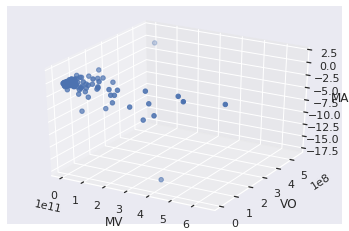

In [11]:
sns.set(style = "darkgrid")
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x_data = pd.to_numeric(X7f['MV'])
y_data = pd.to_numeric(X7f['VO'])
z_data = pd.to_numeric(X7f['MACD'])

ax.set_xlabel("MV")
ax.set_ylabel("VO")
ax.set_zlabel("MACD")

ax.scatter(x_data, y_data, z_data)
plt.show()

In [12]:
# Transform with MinMax to handle VO, MV
# sc = MinMaxScaler()
# X_scaled = sc.fit_transform(X5f)

X_scaled = X5f
## Test without transform? No. We need to perform inverse transform.


# sc = StandardScaler()
# X_scaled = sc.fit_transform(X5f)



# Fit PCA to get Explained Variance: eigenvalues, eigenvectors
pca_3d = decomposition.PCA(n_components=3)
pca_3d.fit(X_scaled)

PCA(n_components=3)

In [13]:
pca_3d.explained_variance_

array([1.64289249, 1.20396576, 0.91077221])

In [14]:
pca_3d.components_

array([[ 0.45941198, -0.50456442, -0.63465087,  0.29861643,  0.20591718],
       [-0.13216157, -0.38036788,  0.12449065, -0.62673837,  0.65540422],
       [ 0.70043333,  0.52083578,  0.24248085,  0.02634736,  0.4226489 ]])

In [15]:
# Transformed with PCA
pca_features = pca_3d.transform(X5f)
df2 = pd.DataFrame(pca_features)
df2['y'] = y['stock'].values
df2 # ...we have 3 feature columns from PCA transformation.

,0,1,2,y
0,3.681079e+06,1.171633e+07,7.555481e+06,ASIA AVIATION
1,5.199048e+06,1.654754e+07,1.067103e+07,ADVANCED INFO SER.
2,8.166471e+03,2.584126e+04,1.670539e+04,AE.THANA SINSAP (THAI.)
3,3.421792e+05,1.089087e+06,7.023218e+05,AMATA
4,7.024750e+05,2.235870e+06,1.441841e+06,ANANDA DEVELOPMENT
...,...,...,...,...
137,1.186986e+06,3.777997e+06,2.436309e+06,VGI
138,7.715162e+06,2.455623e+07,1.583551e+07,VIBHAVADI MEDICAL
139,3.381447e+05,1.076244e+06,6.940400e+05,VANACHAI GROUP
140,6.348171e+06,2.020529e+07,1.302974e+07,WHA


In [16]:
df2 = df2.rename(columns={0:'PC1', 1:'PC2', 2:'PC3'}) # df2 is datafram from PCA output
df2

,PC1,PC2,PC3,y
0,3.681079e+06,1.171633e+07,7.555481e+06,ASIA AVIATION
1,5.199048e+06,1.654754e+07,1.067103e+07,ADVANCED INFO SER.
2,8.166471e+03,2.584126e+04,1.670539e+04,AE.THANA SINSAP (THAI.)
3,3.421792e+05,1.089087e+06,7.023218e+05,AMATA
4,7.024750e+05,2.235870e+06,1.441841e+06,ANANDA DEVELOPMENT
...,...,...,...,...
137,1.186986e+06,3.777997e+06,2.436309e+06,VGI
138,7.715162e+06,2.455623e+07,1.583551e+07,VIBHAVADI MEDICAL
139,3.381447e+05,1.076244e+06,6.940400e+05,VANACHAI GROUP
140,6.348171e+06,2.020529e+07,1.302974e+07,WHA


In [17]:
# Fit k-means to the transformed:  3-D is Euclidean space!!! Pray this works

kmean = KMeans(n_clusters=3, random_state=0)
kmean.fit(df2[['PC1','PC2','PC3']].values)

kmean.cluster_centers_


array([[1.71370809e+06, 5.45443106e+06, 3.51739894e+06],
       [1.03473505e+08, 3.29340997e+08, 2.12381315e+08],
       [2.01988396e+07, 6.42899362e+07, 4.14584948e+07]])

In [18]:
# kmean.labels_
df2['k-mean'] = kmean.labels_
df2

,PC1,PC2,PC3,y,k-mean
0,3.681079e+06,1.171633e+07,7.555481e+06,ASIA AVIATION,0
1,5.199048e+06,1.654754e+07,1.067103e+07,ADVANCED INFO SER.,0
2,8.166471e+03,2.584126e+04,1.670539e+04,AE.THANA SINSAP (THAI.),0
3,3.421792e+05,1.089087e+06,7.023218e+05,AMATA,0
4,7.024750e+05,2.235870e+06,1.441841e+06,ANANDA DEVELOPMENT,0
...,...,...,...,...,...
137,1.186986e+06,3.777997e+06,2.436309e+06,VGI,0
138,7.715162e+06,2.455623e+07,1.583551e+07,VIBHAVADI MEDICAL,0
139,3.381447e+05,1.076244e+06,6.940400e+05,VANACHAI GROUP,0
140,6.348171e+06,2.020529e+07,1.302974e+07,WHA,0


In [19]:
# Group 1

grp1 = df2[df2['k-mean']==1]
print("Group 1: %s stocks" % len(grp1))
grp1 

Group 1: 1 stocks


,PC1,PC2,PC3,y,k-mean
59,1.034735e+08,3.293410e+08,2.123813e+08,JASMINE INTERNATIONAL,1


In [20]:
# Group 2

grp2 = df2[df2['k-mean']==0]
print("Group 2: %s stocks" % len(grp2))
grp2

Group 2: 134 stocks


,PC1,PC2,PC3,y,k-mean
0,3.681079e+06,1.171633e+07,7.555481e+06,ASIA AVIATION,0
1,5.199048e+06,1.654754e+07,1.067103e+07,ADVANCED INFO SER.,0
2,8.166471e+03,2.584126e+04,1.670539e+04,AE.THANA SINSAP (THAI.),0
3,3.421792e+05,1.089087e+06,7.023218e+05,AMATA,0
4,7.024750e+05,2.235870e+06,1.441841e+06,ANANDA DEVELOPMENT,0
...,...,...,...,...,...
137,1.186986e+06,3.777997e+06,2.436309e+06,VGI,0
138,7.715162e+06,2.455623e+07,1.583551e+07,VIBHAVADI MEDICAL,0
139,3.381447e+05,1.076244e+06,6.940400e+05,VANACHAI GROUP,0
140,6.348171e+06,2.020529e+07,1.302974e+07,WHA,0


In [21]:
# Group 3

grp3 = df2[df2['k-mean']==2]
print("Group 3: %s stocks" % len(grp3))
grp3

Group 3: 7 stocks


,PC1,PC2,PC3,y,k-mean
56,1.447077e+07,4.605833e+07,2.970152e+07,IRPC,2
89,1.335711e+07,4.251369e+07,2.741571e+07,PTT,2
107,1.235696e+07,3.933037e+07,2.536288e+07,SAMART DIGITAL ORS,2
114,3.209361e+07,1.021493e+08,6.587274e+07,SUPER ENERGY CORPORATION,2
124,2.232000e+07,7.104129e+07,4.581222e+07,TMB BANK,2
126,2.465085e+07,7.846003e+07,5.059632e+07,TPI POLENE,2
128,2.214258e+07,7.047658e+07,4.544806e+07,TRUE CORPORATION,2


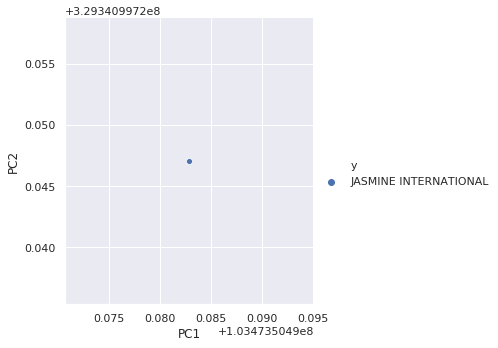

In [22]:
sns.relplot(x="PC1", y="PC2", hue="y", data=grp1)

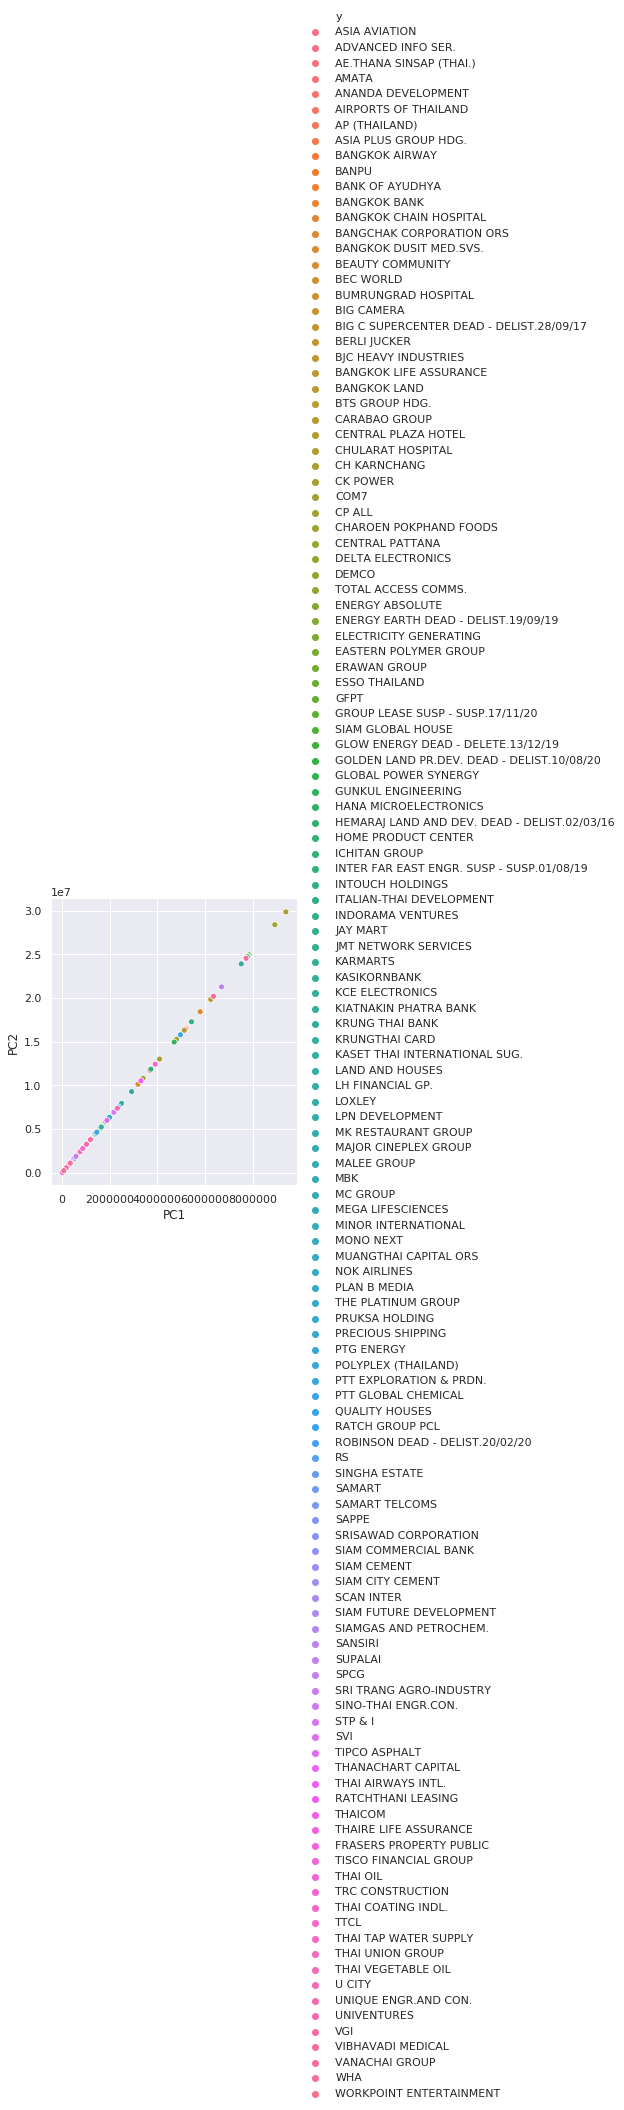

In [23]:
sns.relplot(x="PC1", y="PC2", hue="y", data=grp2)

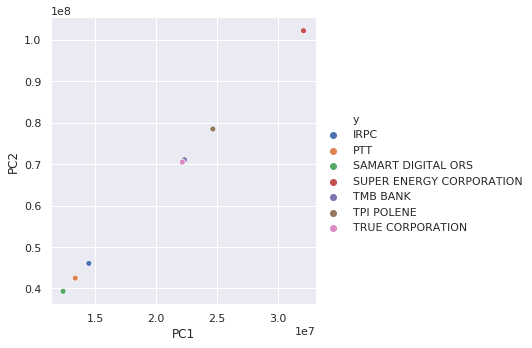

In [24]:
sns.relplot(x="PC1", y="PC2", hue="y", data=grp3)

# Visualise: Plot on PCA Axis

https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

In [25]:
df2.tail()

,PC1,PC2,PC3,y,k-mean
137,1.186986e+06,3.777997e+06,2.436309e+06,VGI,0
138,7.715162e+06,2.455623e+07,1.583551e+07,VIBHAVADI MEDICAL,0
139,3.381447e+05,1.076244e+06,6.940400e+05,VANACHAI GROUP,0
140,6.348171e+06,2.020529e+07,1.302974e+07,WHA,0
141,6.875823e+04,2.187795e+05,1.411021e+05,WORKPOINT ENTERTAINMENT,0


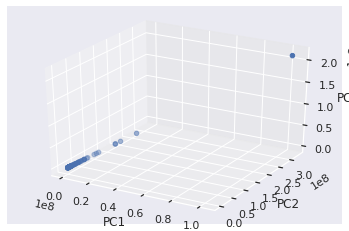

In [26]:



sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = df2['PC1']
y = df2['PC2']
z = df2['PC3']

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

ax.scatter(x, y, z)

plt.show()

In [27]:
df2.to_csv('/home/jovyan/stock_pca_5f.csv')

# Visualise: Plot on Original Axis

Plot the stocks on   MV-VO axis.

In [28]:
f_dim7.to_csv('/home/jovyan/stock_ori.csv')

# f_dim7.merge(df2, on='y')